# Bayesian Data Analysis in Python

Bayesian data analysis is an increasingly popular method of statistical inference, used to determine conditional probability without having to rely on fixed constants such as confidence levels or p-values. In this course, we’ll learn how Bayesian data analysis works, how it differs from the classical approach, and why it’s an indispensable part of our data science toolbox. We’ll get to grips with A/B testing, decision analysis, and linear regression modeling using a Bayesian approach as we analyze real-world advertising, sales, and bike rental data. Finally, we’ll get hands-on with the PyMC3 library, which will make it easier for us to design, fit, and interpret Bayesian models.

## 1. The Bayesian way

Our first steps in the Bayesian world. In this chapter, we’ll be introduced to the basic concepts of probability and statistical distributions, as well as to the famous Bayes' Theorem, the cornerstone of Bayesian methods. Finally, we’ll build our first Bayesian model to draw conclusions from randomized coin tosses.

<img src="fig/this_is_the_way.jpg" width=400  />

What is Bayes? Bayesian inference means updating one's belief about something as the new information becomes available. It is quite different from the classical approach, see the table below:

<img src="fig/bayes_vs_class.png" width=400  />

The main advantages of the Bayesian approach over Frequentist (classical) approach:
- Natural handling of uncertainty (because parameters have distributions!).
- Possibility to include expert opinion or domain knowledge in the model (because probability means the degree of belief!).
- No need to rely on fixed constants such as p-values.
- Statistically correct even with little data.
- Often coincides with frequentist results, but offers more flexibility to build custom models.

Based on the description above, we have the general idea of what the Bayesian approach is all about. Among other things, we know that for a Bayesian, parameters of statistical models are random variables which can be described by probability distributions.

#### 1.1 Probability and Bayes' Theorem
SCENARIO: _You have a regular deck of 52 well-shuffled playing cards. The deck consists of 4 suits, and there are 13 cards in each suite: ranks 2 through 10, a jack, a queen, a king, and an ace. This means that in the whole deck of 52, there are four of each distinct rank: four aces, four kings, four tens, four fives, etc._

Since there are 52 distinct cards, the probability of drawing any one particular card is 1/52. The goal is to calculate the probabilities of drawing some specific combinations of cards, as described in the instructions/comments in the cells below.

In [1]:
# Install packages https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
# !conda install --yes --prefix {sys.prefix} pymc3
# !conda install --yes --prefix {sys.prefix} arviz

In [2]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import uniform, binom
import pymc3 as pm
import arviz as az
from sklearn.model_selection import train_test_split

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Calculate probability of drawing a king or queen
p_king_or_queen = 4*(1/52) + 4*(1/52) # 4 kings OR queens
print("The probability of drawing a king or queen is {0:.2f}.".format(p_king_or_queen))

# Calculate probability of drawing <= 5
p_five_or_less = 4*4*(1/52) # 4 different cards: 2, 3, 4, 5 times 4 each
print("The probability of drawing <= 5 is {0:.2f}.".format(p_five_or_less))

# Calculate probability of drawing four aces
p_all_four_aces = 4*(1/52)*3*(1/51)*2*(1/50)*1*(1/49) # drawing without replacement
print("The probability of drawing all four aces in row is {0:.8f}.".format(p_all_four_aces))

The probability of drawing a king or queen is 0.15.
The probability of drawing <= 5 is 0.31.
The probability of drawing all four aces in row is 0.00000369.


Probably well done! The chance of drawing four aces straight is 0.00037%, so don't hope for it too much! Now that we're an expert in manipulating probabilities, let's take a look at Bayes' Theorem and how to use it to detect spam messages.

SCENARIO: _While browsing your inbox, you have figured out that quite a few of the emails you would rather not waste your time on reading contain exclamatory statements, such as "BUY NOW!!!". You start thinking that the presence of three exclamation marks next to each other might be a good spam predictor! Hence you've prepared a DataFrame called `emails` with two variables: `spam`, whether the email was spam, and `contains_3_exlc`, whether it contains the string "!!!"._

__NOTE:__ The `emails` dataset is not available online and it is built manually for this exercise.

Our job is to calculate the probability of the email __being spam given that it contains three exclamation marks__. Let's tackle it step by step! Here is Bayes' formula for our reference:

$$ P(A | B) = \frac{ P(B | A) \times P(A)}{ P(B) } $$

In [4]:
# build/simulate the dataset 1=TRUE, 0=FALSE
np.random.seed(42)
spam = np.random.binomial(1, 50/205, size=205)
contains_3_excl = np.zeros(len(spam), dtype=int)
emails = pd.DataFrame({'spam':spam, 'contains_3_excl':contains_3_excl})
emails.loc[ emails[emails['spam'] == 1].sample(frac=.6).index, ['contains_3_excl'] ] = 1
emails.loc[ emails[emails['spam'] == 0].sample(frac=.04).index, ['contains_3_excl'] ] = 1
emails.head()

,spam,contains_3_excl
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


In [5]:
# Calculate and print the unconditional probability of spam
p_spam = emails['spam'].mean()
print("The unconditional probability of spam is {0:.2f}.".format(p_spam))

# Calculate and print the unconditional probability of "!!!"
p_3_excl = emails["contains_3_excl"].mean()
print("The unconditional probability of \"!!!\" is {0:.2f}.".format(p_3_excl))

# Calculate and print the probability of "!!!" given spam
p_3_excl_given_spam = emails.loc[emails["spam"] == 1 ]["contains_3_excl"].mean() 
print("The probability of \"!!!\" given spam is {0:.2f}.".format(p_3_excl_given_spam))

# Calculate and print the probability of spam given "!!!"
p_spam_given_3_excl = p_3_excl_given_spam * p_spam / p_3_excl
print("The probability of spam given \"!!!\" is {0:.2f}.".format(p_spam_given_3_excl))

The unconditional probability of spam is 0.25.
The unconditional probability of "!!!" is 0.18.
The probability of "!!!" given spam is 0.61.
The probability of spam given "!!!" is 0.84.


If an email contains the '!!!', you can be 84% sure it is spam! Next, let's use Bayes' Theorem in practice once again, but this time without the data neatly gathered in a DataFrame!

SCENARIO: _A doctor suspects a disease in their patient, so they run a medical test. The test's manufacturer claims that 99% of sick patients test positive, while the doctor has observed that the test comes back positive in 2% of all cases. The suspected disease is quite rare: only 1 in 1000 people suffer from it._

The test result came back positive. __What is the probability that the patient is indeed sick?__ We can use Bayes' Theorem to answer this question. Here is what you should calculate:

$$ P(\text{sick} | \text{positive}) = \frac{ P(\text{positive} | \text{sick}) \times P(\text{sick})}{ P(\text{positive}) } $$

In [6]:
p_sick = 1/1000
p_pos = 0.02
p_pos_sick = 0.99
print(p_pos_sick * p_sick / p_pos)

0.049499999999999995


Not very intuitive, is it? Even though the test is great at discovering the disease and raises false alarms rather seldom, a positive result means only a 5% probability that the patient is sick!

#### 1.2 Tasting the Bayes

In this part we will use a custom `get_heads_prob()` function that estimates the probability of success of a binomial distribution. In this exercise, we will use it and verify whether it does its job well in a coin-flipping experiment.

Watch out for the confusion: there are two different probability distributions involved! One is the binomial, which we use to model the coin-flipping. It's a discrete distribution with two possible values (heads or tails) parametrized with the probability of success (tossing heads). The Bayesian estimate of this parameter is another, continuous probability distribution. We don't know what kind of distribution it is, but we can estimate it with `get_heads_prob()` and visualize it.

In [7]:
def get_heads_prob(tosses):
    """
    Estimates the probability of success of a binomial distribution.

    Parameters
    ----------
    tosses : array
        List of coin-flipping trials with two possible values 0s and 1s.

    Returns
    -------
    probability distribution: array
        continuous probability of success (tossing heads).

    See also
    --------
    https://campus.datacamp.com/courses/bayesian-data-analysis-in-python/the-bayesian-way?ex=9.
    """
    
    num_heads = np.sum(tosses)
    return np.random.beta(num_heads + 1, 
                          len(tosses) - num_heads + 1, 
                          1000)

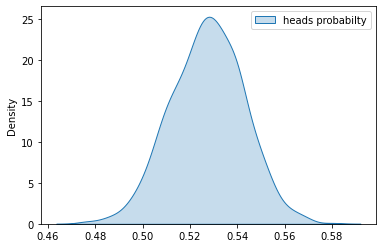

In [8]:
# Generate 1000 coin tosses of a "fair" coin
tosses = np.random.binomial(1, 0.5, size=1000)

# Estimate the heads probability
heads_prob = get_heads_prob(tosses)

# Plot the distribution of heads probability
sns.kdeplot(heads_prob, shade=True, label="heads probabilty")
plt.legend()
plt.show()

The density plot peaks around 50%, indicating that the model has estimated the heads probability well. Now that we're familiar with `get_heads_prob()`, let's explore it in more detail in the next exercise!

SCENARIO: _Imagine you are a frequentist (just for a day), and you've been tasked with estimating the probability of tossing heads with a (possibly biased) coin, but without observing any tosses. What would you say? It's impossible, there is no data! Then, you are allowed to flip the coin once. You get tails. What do you say now? Well, if that's all your data, you'd say the heads probability is 0%._

You can probably feel deep inside that these answers are not the best ones. But what would be better? What would a Bayesian say? Let's find out!

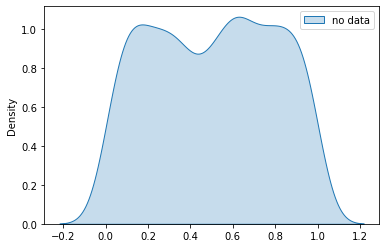

In [9]:
# Estimate and plot heads probability based on no data
heads_prob_nodata = get_heads_prob([]) # heads probability based on an empty list
sns.kdeplot(heads_prob_nodata, shade=True, label="no data")
plt.legend()
plt.show()

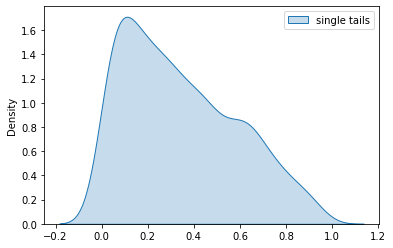

In [10]:
# Estimate and plot heads probability based on a single tails
heads_prob_onetails = get_heads_prob([0]) # a single tail (a list with a single 0)
sns.kdeplot(heads_prob_onetails, shade=True, label="single tails")
plt.legend()
plt.show()

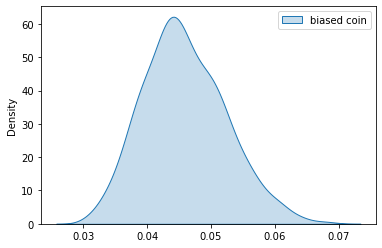

In [11]:
# Estimate and plot heads probability based on 1000 tosses with a biased coin which comes up heads only 5% of all times
biased_tosses = np.random.binomial(1, 0.05, size=1000)
heads_prob_biased = get_heads_prob(biased_tosses)
sns.kdeplot(heads_prob_biased, shade=True, label="biased coin")
plt.legend()
plt.show()

That's interesting! With no data, each possible value of the heads probabilty is equally likely! That's the Bayesian way of saying 'we don't know'. Having seen a single tails, the model suspects that tails is more likely than heads, but since there is so little data, it is not very sure about it, so other values are possible, too. Having seen 1000 tosses, 5% of them heads, the model is certain: the heads probability is around 5%. __We have just witnessed the Bayesian approach at its core: as more data come in, we update our belief about the parameter, and with more data we become more certain about our estimate!__

In the last two exercises, we have examined the `get_heads_prob()` function to discover how the model estimates the probability of tossing heads and how it updates its estimate as more data comes in.

Now, let's get down to some serious stuff:

SCENARIO: _Would you like to play coin flipping against your friend? She is willing to play, as long as you use her special lucky coin. The tosses variable contains a list of 1000 results of tossing her coin. Will you play?_

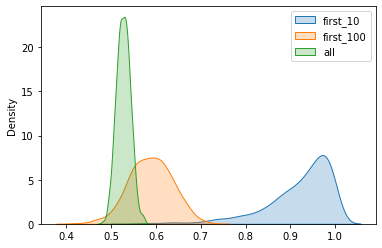

In [12]:
# build/simulate the dataset
np.random.seed(42)
tossestosses = np.random.binomial(1, 0.75, size=1000)

# Assign first 10 and 100 tosses to separate variables
tosses_first_10 = tosses[:10]
tosses_first_100 = tosses[:100]

# Get head probabilities for first 10, first 100, and all tossses
heads_prob_first_10 = get_heads_prob(tosses_first_10)
heads_prob_first_100 = get_heads_prob(tosses_first_100)
heads_prob_all = get_heads_prob(tosses)

# Plot density of head probability for each subset of tosses
sns.kdeplot(heads_prob_first_10, shade=True, label="first_10")
sns.kdeplot(heads_prob_first_100, shade=True, label="first_100")
sns.kdeplot(heads_prob_all, shade=True, label="all")
plt.legend()
plt.show()

The coin seems to be biased, it is more likely to come up heads than tails. You're right refusing to play with this particular coin. The chance it comes up heads is 75% to be precise, and the model got it right - having seen all 1000 tosses, the estimated distribution peaks at 0.75. With smaller data samples, however, the model didn't have the chance to learn the true value. You can see how uncertain it is from the width of the corresponding distributions. Are you curious how this model works, and how it updates its estimates with more data? Head off to Chapter 2 to find out!

## 2. Bayesian estimation

It’s time to look under the Bayesian hood. We’ll learn how to apply Bayes' Theorem to drug-effectiveness data to estimate the parameters of probability distributions using the grid approximation technique, and update these estimates as new data become available. Next, we’ll learn how to incorporate prior knowledge into the model before finally practicing the important skill of reporting results to a non-technical audience.

#### 2.1 Under the Bayesian hood

SCENARIO: _Congratulations! You have just been hired as a data analyst at your government's Department of Health. The cabinet is considering the purchase of a brand-new drug against a deadly and contagious virus. There are some doubts, however, regarding how effective the new drug is against the virus. You have been tasked with estimating the drug's efficacy rate, i.e. the percentage of patients cured by the drug._

_An experiment was quickly set up in which 10 sick patients have been treated with the drug. Once you know how many of them are cured, you can use the binomial distribution with a cured patient being a "success" and the efficacy rate being the "probability of success". While you are waiting for the experiment's results, you decide to prepare the parameter grid._

In [13]:
# Create cured patients array from 1 to 10
num_patients_cured = np.arange(0, 11, 1)

# Create efficacy rate array from 0 to 1 by 0.01 (0%-100%)
efficacy_rate = np.arange(0, 1.01, 0.01)

# Combine the two arrays in one DataFrame
# meaning creating a grid of all possible combination of success and their probabilities
df = pd.DataFrame([(x, y) for x in num_patients_cured for y in efficacy_rate])

# Name the columns
df.columns = ['num_patients_cured', 'efficacy_rate']

# Print df
display(df)

,num_patients_cured,efficacy_rate
0,0,0.00
1,0,0.01
2,0,0.02
3,0,0.03
4,0,0.04
...,...,...
1106,10,0.96
1107,10,0.97
1108,10,0.98
1109,10,0.99


We have prepared a fine grid of possible values for the parameter we want to estimate (the efficacy rate), for all possible results of the experiment (the number of patients cured by the drug). Uh-oh 🤓, it looks like the results have just arrived! Let's make use of them in the next exercise!

According to the experiment's outcomes, out of __10 sick patients treated with the drug, 9 have been cured__. What can we say about the drug's efficacy rate based on such a small sample? Assume we have no prior knowledge whatsoever regarding how good the drug is.

$$ P(\text{parameters} | \text{data}) = \frac{ P(\text{data} | \text{parameters}) \times P(\text{parameters})}{ P(\text{data}) } $$

- __P(parameters | data) → posterior distribution:__ what we know about the parameters after having seen the data
- __P(parameters) → prior distribution:__ what we know about the parameters before seeing any data
- __P(data | parameters) → likelihood__ of the data according to our statistical model
- __P(data) →__ scaling factor


In [14]:
# Calculate the prior efficacy rate and the likelihood
df["prior"] = uniform.pdf(df["efficacy_rate"]) # meaning that all scenarios have the same chance to happen
df["likelihood"] = binom.pmf(df["num_patients_cured"], 10, df["efficacy_rate"]) # here we use the sample size 

# Calculate the posterior efficacy rate and scale it to sum up to one
# We use the function above to finalize our parameters grid
df["posterior_prob"] = df["prior"] * df["likelihood"]
df["posterior_prob"] /= df["posterior_prob"].sum() # scale the posterior_prob to get a sum of 1

# Print df
display(df)

,num_patients_cured,efficacy_rate,prior,likelihood,posterior_prob
0,0,0.00,1.0,1.000000,0.009901
1,0,0.01,1.0,0.904382,0.008954
2,0,0.02,1.0,0.817073,0.008090
3,0,0.03,1.0,0.737424,0.007301
4,0,0.04,1.0,0.664833,0.006583
...,...,...,...,...,...
1106,10,0.96,1.0,0.664833,0.006583
1107,10,0.97,1.0,0.737424,0.007301
1108,10,0.98,1.0,0.817073,0.008090
1109,10,0.99,1.0,0.904382,0.008954


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_1232\1192329434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9_of_10_cured["posterior_prob"] /= df_9_of_10_cured["posterior_prob"].sum() # scale the posterior_prob to get a sum of 1


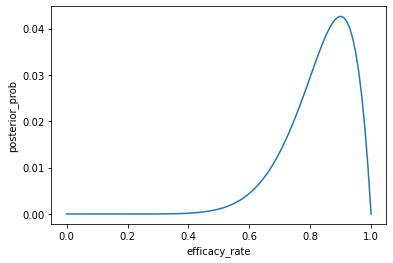

In [15]:
# Compute the posterior probability of observing 9 cured patients
df_9_of_10_cured = df.loc[df["num_patients_cured"] == 9]
df_9_of_10_cured["posterior_prob"] /= df_9_of_10_cured["posterior_prob"].sum() # scale the posterior_prob to get a sum of 1

# Plot the drug's posterior efficacy rate
sns.lineplot(data=df_9_of_10_cured, x="efficacy_rate", y="posterior_prob")
plt.show()

As we might have expected, observing 9 out of 10 patients cured results in the posterior efficacy rate of 90% being very likely. Notice, however, how much uncertainty there is in the posterior distribution: even the efficacy of 50% is plausible. This is the result of a very small data sample and a great example of how Bayesian parameter estimates incorporate uncertainty!

Unfortunately, due to a small data sample, this distribution is quite wide, indicating much uncertainty regarding the drug's quality. Luckily, testing of the drug continues, and a group of another 12 sick patients 🤒 have been treated, 10 of whom were cured. We need to update our posterior distribution with these new data!

This is easy to do with the Bayesian approach. We simply need to run the grid approximation similarly as before, but with a different prior. We can use all our knowledge about the efficacy rate (embodied by the posterior distribution from the previous exercise) as a new prior! Then, we recompute the likelihood for the new data, and get the new posterior!

In [16]:
# Create new cured patients array from 1 to 12
new_num_patients_cured = np.arange(0, 13, 1)

# The efficacy rate didn't change
# Combine the two arrays in one DataFrame
# meaning creating a grid of all possible combination of success and their probabilities
new_df = pd.DataFrame([(x, y) for x in new_num_patients_cured for y in efficacy_rate])

# Name the columns
new_df.columns = ['num_patients_cured', 'efficacy_rate']

# Print df
display(new_df)

# NOTE: since we know that we have 10 cured personas, we could only build a grid for new_num_patients_cured=10

,num_patients_cured,efficacy_rate
0,0,0.00
1,0,0.01
2,0,0.02
3,0,0.03
4,0,0.04
...,...,...
1308,12,0.96
1309,12,0.97
1310,12,0.98
1311,12,0.99


,num_patients_cured,efficacy_rate,prior,likelihood,posterior_prob
0,0,0.00,0.000000e+00,1.000000,0.000000e+00
1,0,0.01,1.089999e-18,0.886385,9.661585e-19
2,0,0.02,5.524422e-16,0.784717,4.335107e-16
3,0,0.03,2.102102e-14,0.693842,1.458528e-14
4,0,0.04,2.770780e-13,0.612710,1.697684e-13
...,...,...,...,...,...
1308,12,0.96,3.049944e-02,0.612710,1.868731e-02
1309,12,0.97,2.511063e-02,0.693842,1.742282e-02
1310,12,0.98,1.835927e-02,0.784717,1.440683e-02
1311,12,0.99,1.005791e-02,0.886385,8.915176e-03


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_1232\3985422740.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10_of_12_cured["posterior_prob"] /= df_10_of_12_cured["posterior_prob"].sum()


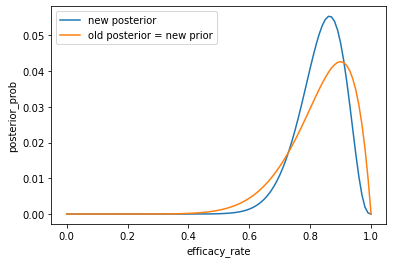

In [17]:
# Build a new grid and assign old posterior to new prior and calculate likelihood
new_prior = [df_9_of_10_cured["posterior_prob"] for i in  new_num_patients_cured]
new_prior = pd.concat(new_prior, ignore_index=True)
new_df["prior"] = new_prior
new_df["likelihood"] = binom.pmf(new_df["num_patients_cured"], 12, new_df["efficacy_rate"])

# Calculate new posterior and scale it
new_df["posterior_prob"] = new_df["prior"] * new_df["likelihood"]
new_df["posterior_prob"] /= new_df["posterior_prob"].sum()
display(new_df)

# Compute the posterior probability of observing 10 cured patients
df_10_of_12_cured = new_df.loc[ new_df['num_patients_cured'] == 10]
df_10_of_12_cured["posterior_prob"] /= df_10_of_12_cured["posterior_prob"].sum()

# Plot the drug's posterior efficacy rate
sns.lineplot(data=df_10_of_12_cured, x="efficacy_rate", y="posterior_prob", label="new posterior")
sns.lineplot(data=df_9_of_10_cured, x="efficacy_rate", y="posterior_prob", label="old posterior = new prior")
plt.legend()
plt.show()

The knowledge about the first 10 patients is already encoded in the old posterior, which became the new prior. The difference between these two distributions reflects what we have learned from the data on all patients: the first 10, and the next 12.

#### 2.2 Prior belief
Choosing the prior distribution is a very important step in Bayesian data analysis. Some things to remember before choosing the prior:

- Prior distribution chosen before we see the data.
- Prior choice can impact posterior results (especially with little data)
- To avoid cherry-picking, prior choices should be:
    - clearly stated,
    - explainable: based on previous research, sensible assumptions, expert opinion, etc.
- Some priors, multiplied with specific likelihoods, yield known posteriors. They are known as __conjugate priors__.

SCENARIO: _You continue working on your task to estimate the new drug's efficacy, but with the small data sample you had, you know there is a lot of uncertainty in your estimate. Luckily, a couple of neighboring countries managed to conduct more extensive experiments and have just published their results. You can use them as priors in your analysis!_

_Having browsed all the publications, you conclude that the reported efficacy rates are mostly between 70% and 90%. A couple of results below 50% were recorded too, but not many._

_You have just decided to use a Beta(5, 2) prior for the efficacy rate. You are also using the binomial distribution to model the data (curing a sick patient is a "success", remember?). Since the beta distribution is a __conjugate prior__ for the binomial likelihood, you can simply simulate the posterior! Can you simulate the posterior distribution? Recall that altogether we have data on 22 patients, 19 of whom have been cured._

We know that if the prior is $Beta(a, b)$, then the posterior is $Beta(x, y)$, with:

$x = NumberOfSuccesses + a$\
$y = NumberOfObservations - NumberOfSuccesses + b$

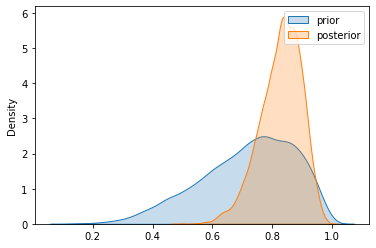

In [18]:
# Define the number of patients treated and cured
num_patients_treated = 22 # 𝑁𝑢𝑚𝑏𝑒𝑟𝑂𝑓𝑂𝑏𝑠𝑒𝑟𝑣𝑎𝑡𝑖𝑜𝑛𝑠
num_patients_cured = 19 # 𝑁𝑢𝑚𝑏𝑒𝑟𝑂𝑓𝑆𝑢𝑐𝑐𝑒𝑠𝑠𝑒𝑠

# Simulate 10000 draws from the posterior distribuition
prior = np.random.beta(5, 2, 10000)
posterior_draws = np.random.beta(19 + 5, 22 - 19 + 2, 10000)


# Plot the posterior distribution
sns.kdeplot(prior, shade=True, label="prior")
sns.kdeplot(posterior_draws, shade=True, label="posterior")
plt.legend()
plt.show()

Notice that the posterior distribuion has a slightly longer tail on the left-hand side, allowing for efficacy rates as small as 50%, even though in your data you observe 86% (19 out of 22). This is the impact of the prior: we learn not only from our own small data, but also from other countries' experience! Now that we know how obtain posterior distributions of the parameters, let's talk about how to report these results!

#### 2.3 Reporting Bayesian results

SCENARIO: _You continue working at your government's Department of Health. You have been tasked with filling the following memo with numbers, before it is sent to the secretary._

_"Based on the experiments carried out by ourselves and neighboring countries, should we distribute the drug, we can expect __XXX__ infected people to be cured. There is a 50% probability the number of cured infections will amount to at least __XXX__, and with 90% probability it will not be less than __XXX__."_

The array of posterior draws of the drug's efficacy rate we have estimated before is available to us as `posterior_draws`.

We need to calculate the three numbers needed to fill in the memo, knowing there are 100,000 infections at the moment. 

In [19]:
# Calculate the expected number of people cured
cured_expected = np.mean(posterior_draws) * 100000

# Calculate the minimum number of people cured with 50% probability
min_cured_50_perc = np.median(posterior_draws) * 100000

# Calculate the minimum number of people cured with 90% probability
min_cured_90_perc = np.percentile(posterior_draws, 10) * 100000

# Print the filled-in memo
memo = f"""Based on the experiments carried out by ourselves and neighboring countries, 
should we distribute the drug, we can expect {int(cured_expected)} infected people to be cured.
There is a 50% probability the number of cured infections will amount to at least {int(min_cured_50_perc)},
and with 90% probability it will not be less than {int(min_cured_90_perc)}."""

print(memo)

Based on the experiments carried out by ourselves and neighboring countries, 
should we distribute the drug, we can expect 82702 infected people to be cured.
There is a 50% probability the number of cured infections will amount to at least 83459,
and with 90% probability it will not be less than 73305.


Our memo compresses the posterior distribution of the drug's efficacy to a couple of useful numbers, certainly helping the secretary decide whether to buy the new drug. However, these numbers convey no information as to how uncertain the estimation is. Let's try quantifying this uncertainty next!

SCENARIO: _You know that reporting bare point estimates is not enough. It would be great to provide a measure of uncertainty in the drug's efficacy rate estimate, and you have all the means to do so. You decide to add the following to the memo._

_"The experimental results indicate that with a 90% probability the new drug's efficacy rate is between __XXX__ and __XXX__, and with a 95% probability it is between __XXX__ and __XXX__."_

We will need to calculate two credible intervals: one of 90% and another of 95% probability. For example:

<img src="fig/hpi.png" width=600  />

In [20]:
# Calculate the Highest Posterior Density (HDP) credible interval of 90% 
ci_90 = az.hdi(posterior_draws, hdi_prob=0.9)

# Calculate HPD credible interval of 95%
ci_95 = az.hdi(posterior_draws, hdi_prob=0.95)

# Print the memo
memo_2 = f"""The experimental results indicate that with a 90% probability 
the new drug's efficacy rate is between {np.round(ci_90[0], 2)} and {np.round(ci_90[1], 2)}, 
and with a 95% probability it is between {np.round(ci_95[0], 2)} and {np.round(ci_95[1], 2)}."""

print(memo_2)

The experimental results indicate that with a 90% probability 
the new drug's efficacy rate is between 0.72 and 0.94, 
and with a 95% probability it is between 0.69 and 0.95.


Notice how the 95% interval is wider than the 90% interval. This makes sense: the wider the interval, the greater the chance the parameter will fall into it. Should you want an interval a parameter is 100% certain to fall into, it would have to cover all possible values: from 0 to 1! Now, calculating the HPD was the easy part.

What is the proper Bayesian interpretation of 90% credible interval in the context of the drug's efficacy?

The probability that the drug's true efficacy rate lies in the interval (0.72, 0.94) is 90%.

That's the Bayesian interpretation of a credible interval. Since the drug's true efficacy rate is considered a random variable, we can make probabilistic statements about it, as in: "the probability that it takes a particular value or that it lies in a particular interval is X%". Next, in Chapter 3, we will apply all we've learned about the Bayesian approach to practical problems: A/B testing, decision analysis, and regression modeling.

## 3. Bayesian inference

Apply our newly acquired Bayesian data analysis skills to solve real-world business challenges. We’ll work with online sales marketing data to conduct A/B tests, decision analysis, and forecasting with linear regression models.

#### 3.1 A/B testing

In the upcoming few exercises, we will be using the `simulate_beta_posterior()` function. In this exercise, we will get a feel for what the function is doing by carrying out the computations it performs.

SCENARIO: _You are given a list of ten coin tosses, called `tosses`, in which 1 stands for heads, 0 for tails, and we define heads as a "success". To simulate the posterior probability of tossing heads, you will use a beta prior._

Recall that if the prior is $Beta(a, b)$, then the posterior is $Beta(x, y)$, with:

$x = NumberOfSuccesses + a$\
$y = NumberOfObservations - NumberOfSuccesses + b$

In [21]:
def simulate_beta_posterior(trials, beta_prior_a, beta_prior_b):
    """
    Estimates the probability of success of a binomial distribution assuming Beta(a, b) prior.

    Parameters
    ----------
    trials : array
        List of trials with two possible values 0s and 1s (binomial distribution).
        
    beta_prior_a: integer
        "a" parameter of prior Beta(a, b).
    
    beta_prior_b: integer
        "b" parameter of prior Beta(a, b).

    Returns
    -------
    probability distribution: array
        continuous probability of success (1s).

    See also
    --------
    https://campus.datacamp.com/courses/bayesian-data-analysis-in-python/bayesian-inference?ex=1.
    """
    num_successes = np.sum(trials)
    posterior_draws = np.random.beta(
        num_successes + beta_prior_a,
        len(trials) - num_successes + beta_prior_b,
        10000
    )
    return posterior_draws

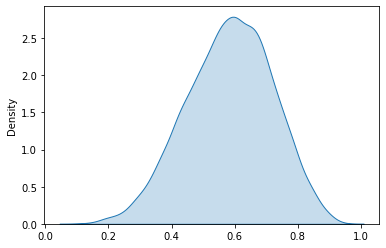

In [22]:
# data
tosses = [1, 0, 0, 1, 0, 1, 1, 1, 0, 1]

# Set prior parameters and calculate number of successes
beta_prior_a = 1
beta_prior_b = 1
num_successes = np.sum(tosses)

# Generate 10000 posterior draws
posterior_draws = np.random.beta(
    num_successes + beta_prior_a, 
    10 - num_successes + beta_prior_b, 
    10000
)  

# Plot density of posterior_draws
sns.kdeplot(posterior_draws, shade=True)
plt.show()

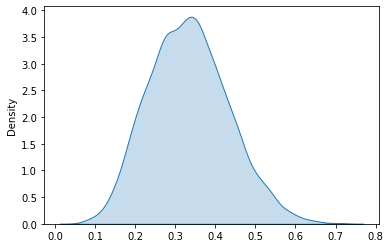

In [23]:
# data
tosses = [1, 0, 0, 1, 0, 1, 1, 1, 0, 1]

# Set prior parameters and calculate number of successes
beta_prior_a = 1
beta_prior_b = 10
num_successes = np.sum(tosses)

# Generate 10000 posterior draws
posterior_draws = np.random.beta(
    num_successes + beta_prior_a, 
    10 - num_successes + beta_prior_b, 
    10000
)  

# Plot density of posterior_draws
sns.kdeplot(posterior_draws, shade=True)
plt.show()

Now we see what `simulate_beta_posterior()` is doing: based on the binomial data and the prior, it samples posterior draws. Notice how using the Beta(1, 10) prior shifts the posterior to the left compared to Beta(1, 1). This effect is quite strong, as there is little data: just 10 coin flips. Let's move on to A/B testing!

SCENARIO: _After a successful career episode at the Department for Health, you switch to marketing. Your new company has just run two pilot advertising campaigns: one for sneakers, and one for clothes. Your job is to find out which one was more effective as measured by the click-through rate and should be rolled out to a larger audience._

_You decide to run A/B testing, modeling the data using the binomial likelihood. You found out that a typical click-through rate for the previous ads has been around 15% recently, with results varying between 5% and 30% (include about 95% of the data = two sigmas). Based on this, you conclude that $Beta(10,50)$ would be a good prior for the click-through rate._

Knowing $\mu$ and $\sigma$ of the data, we can calculate the parameters of Beta distribution as [follows](https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance):

$$ \alpha = \left( \frac{1 - \mu}{\sigma ^2} - \frac{1}{\mu} \right) \times \mu ^2 $$
$$ \beta = \alpha \times \left( \frac{1}{\mu} - 1 \right) $$

In [24]:
# load data
ads = pd.read_csv("data/ads.csv")
display(ads.head())

,user_id,product,site_version,time,banner_clicked
0,f500b9f27ac611426935de6f7a52b71f,clothes,desktop,2019-01-28 16:47:08,0
1,cb4347c030a063c63a555a354984562f,sneakers,mobile,2019-03-31 17:34:59,0
2,89cec38a654319548af585f4c1c76b51,clothes,mobile,2019-02-06 09:22:50,0
3,1d4ea406d45686bdbb49476576a1a985,sneakers,mobile,2019-05-23 08:07:07,0
4,d14b9468a1f9a405fa801a64920367fe,clothes,mobile,2019-01-28 08:16:37,0


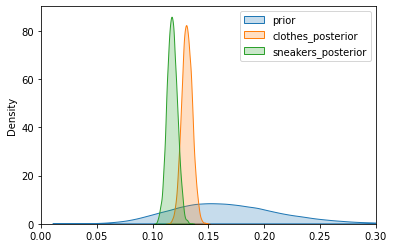

In [25]:
# Generate prior draws: simulate 100000 draws from the prior distribution,
prior_draws = np.random.beta(10, 50, 100000)


# Extract the banner_clicked column for each product
clothes_clicked = ads.loc[ads["product"] == "clothes"]["banner_clicked"]
sneakers_clicked = ads.loc[ads["product"] == "sneakers"]["banner_clicked"]

# Simulate posterior draws for each product
clothes_posterior = simulate_beta_posterior(clothes_clicked, 10, 50)
sneakers_posterior = simulate_beta_posterior(sneakers_clicked, 10, 50)

# Plot the prior
sns.kdeplot(prior_draws, shade=True, label="prior")
sns.kdeplot(clothes_posterior, shade=True, label="clothes_posterior")
sns.kdeplot(sneakers_posterior, shade=True, label="sneakers_posterior")
plt.legend()
plt.xlim(0, 0.3)
plt.show()

Based on the plot above we know:
- The click rate posterior distribution for sneakers is higher, indicating less uncertainty, i.e. we are more certain about the click rate estimate for sneakers than for clothes. 
- Although clothes are most likely doing better, it is not impossible that it's actually the other way around. For instance, it's possible (even if not very likely) for the clothes click ratio to be 12%, and for the sneakers click ratio to be 13%.
- We've heard that previous campaigns yielded a click ratio of between 5% and 30%, with the average of 15%. Both new campaigns seem to be close that average, with sneakers posterior peaking at around 11.5%, and sneakers posterior at 13%.


Since the two posteriors overlap we cannot be sure is the clothes ads are doing better than sneakers ads, so it is actually possible for the sneakers campaign to be bettter. But how likely is it? Let's find out in the next exercise!

We have just discovered that clothes ads are likely to have a higher click ratio than sneakers ads. But what is the exact probability that this is the case? To find out, we will have to calculate the posterior difference between clothes and sneakers click rates. Then, we will calculate a credible interval for the difference to measure the uncertainty in the estimate. Finally, we will calculate the percentage of cases where this difference is positive, which corresponds to clothes click rate being higher. Let's get on with it!

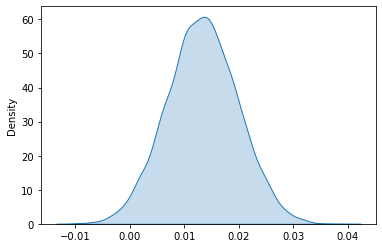

[0.00294961 0.02458297]
0.9802


In [26]:
# Calculate posterior difference and plot it
diff = clothes_posterior - sneakers_posterior
sns.kdeplot(diff, shade=True, label="diff")
plt.show()

# Calculate and print 90% credible interval of posterior difference
interval = az.hdi(diff, hdi_prob=0.9)
print(interval)

# Calculate and print probability of clothes ad being better
clothes_better_prob = (diff > 0).mean()
print(clothes_better_prob)

Take a look at the posterior density plot of the difference in click rates: it is very likely positive, indicating that clothes are likely better. The credible interaval indicates that with 90% probability, the clothes ads click rate is up to 2.4 percentage points higher than the one for sneakers. Finally, the probability that the clothes click rate is higher is 98%. Great! But there is a 2% chance that actually sneakers ads are better! How great is that risk?

We have concluded that with 98% probability, clothes ads have a higher click-through ratio than sneakers ads. This suggests rolling out the clothes campaign to a larger audience. However, there is a 2% risk that it's the sneakers ads that are actually better. If that's the case, how many clicks do we lose if we roll out the clothes campaign?

The answer to this is the expected loss: the average posterior difference between the two click-through ratios given that sneakers ads do better. To calculate it, you only need to take the entries in the posterior difference where the sneakers click-through rate is higher and compute their average.

In [27]:
# Slice diff to take only cases where it is negative
loss = diff[diff < 0]

# Compute and print expected loss
expected_loss = loss.mean()
print(expected_loss)

-0.002342626713681621


We can sefely roll out the clothes campaign to a larger audience. We are 98% sure it has a higher click rare, and even if the 2% risk of this being a wrong decision materializes, we will only lose 0.2 percentage points in the click rate, which is a very small risk!

##### 3.2 Decision analysis

SCENARIO: _Your journey in marketing continues. You have already calculated the posterior click rates for clothes and sneakers ads, available in your workspace as `clothes_posterior` and `sneakers_posteriors`, respectively. Your boss, however, is not interested in the distributions of click rates. They would like to know what would be the cost of rolling out an ad campaign to 10,000 users. The company's advertising partner charges \\$2.5 per click on a mobile device and $2 on a desktop device. Your boss is interested in the cost of the campaign for each product (clothes and sneakers) on each platform (mobile and desktop): four quantities in total._

Let's compare these four posterior costs using the forest plot from `pymc3`, which has been imported for you as `pm`.

C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_1232\3777350533.py:14: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(ads_costs, hdi_prob=0.99)


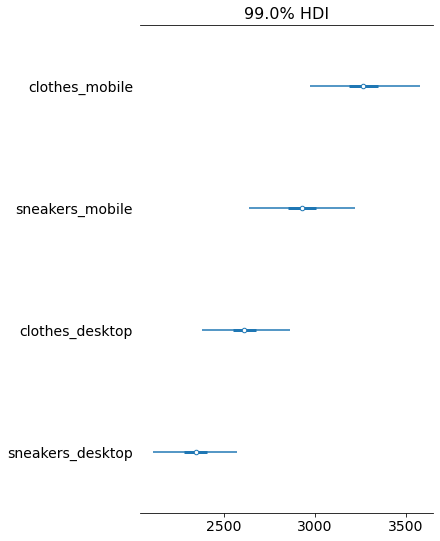

In [28]:
# Calculate distributions of the numbers of clicks for clothes and sneakers
clothes_num_clicks = clothes_posterior * 10000
sneakers_num_clicks = sneakers_posterior * 10000

# Calculate cost distributions for each product and platform
ads_costs = {
    "clothes_mobile": clothes_num_clicks * 2.5,
    "sneakers_mobile": sneakers_num_clicks * 2.5,
    "clothes_desktop": clothes_num_clicks * 2,
    "sneakers_desktop": sneakers_num_clicks * 2,
}

# Draw a forest plot of ads_costs
pm.forestplot(ads_costs, hdi_prob=0.99)
plt.show()

Based on the plot we see that:
- The cost estimate for the clothes campaign on mobile devices is more uncertain than the one for desktop devices. (The wider the credible interval, the more values are possible with a given probability, and hence the more uncertainty in the estimate.)
- If the goal was to reduce the costs, then going for the sneakers campaign on desktop devices would be a good decision. The sneakers-desktop cost distribution's point estimate is the smallest among all campaigns. Even in the worst case scenario, if we end up at the tip of the right whisker paying around \\$2600 for the campaign, it's still less than the midpoint of the second-best clothes-desktop campaign!

__This statement is wrong:__ _It's completely impossible for the clothes-mobile cost to be lower than the sneakers-desktop cost._ The ends of the whiskers mark the 99% credible interval, so there is a 1% chance the cost will fall outside of it. It's very, very unlikely, but there is a slim chance that the clothes-mobile cost will turn out lower. It's important to stay cautious when communicating possible scenarios -- that's the thing with probability, it's rarely the case that something is 'completely impossible'!

SCENARIO: _Good job translating the posterior click rates into cost distributions! In the meantime, a new company policy has been released. From now on, the goal of the marketing department is not to minimize the costs of campaigns, which was quite ineffective, but rather to maximize the profit. Can you adjust your findings accordingly, knowing that the expected revenue per click from a mobile ad is \\$3.4, and the one from a desktop ad is $3? To calculate the profit, you need to calculate the revenue from all clicks, then subtract the corresponding cost from it._


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_1232\922092917.py:10: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(ads_profit, hdi_prob=0.99)


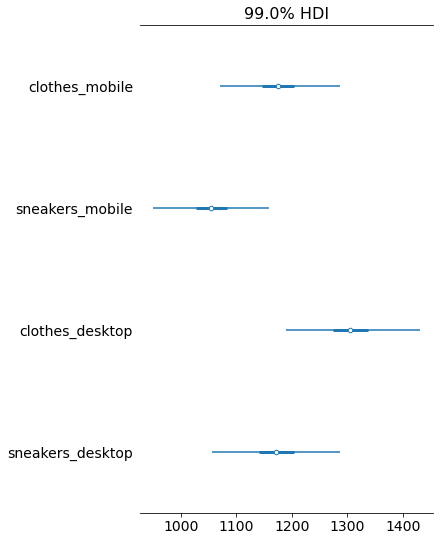

In [29]:
# Calculate profit distributions for each product and platform
ads_profit = {
    "clothes_mobile": clothes_num_clicks * 3.4 - ads_costs["clothes_mobile"],
    "sneakers_mobile": sneakers_num_clicks * 3.4 - ads_costs["sneakers_mobile"],
    "clothes_desktop": clothes_num_clicks * 3 - ads_costs["clothes_desktop"],
    "sneakers_desktop": sneakers_num_clicks * 3 - ads_costs["sneakers_desktop"],
}

# Draw a forest plot of ads_profit
pm.forestplot(ads_profit, hdi_prob=0.99)
plt.show()

Notice how shifting focus from costs to profit has changed the optimal decision. The sneakers-desktop campaign which minimizes the cost is not the best choice when we care about the profit. Based on these results, we would be more likely to invest in the clothes-desktop campaign, wouldn't you? Let's continue to the final lesson of this chapter, where we look at regression and forecasting, the Bayesian way!

#### 3.3 Regression and forecasting

SCENARIO: _You have been tasked with building a predictive model to forecast the daily number of clicks based on the numbers of clothes and sneakers ads displayed to the users. You decide to use Bayesian linear regression. You've defined your model as follows:_

$$numClicks \sim \mathcal{N}(\beta_0 + \beta_1 clothesAdsShown + \beta_2 sneakersAdsShown,\,\sigma)$$\
$$\beta_0 \sim \mathcal{N}(0, 0.001)$$\
$$\beta_1 \sim \mathcal{N}(0.1, 0.3)$$\
$$\beta_2 \sim \mathcal{N}(0.2, 0.2)$$\
$$\\sigma \sim \mathcal{U}(0, 50)$$

Based on the model above we can say that:
- The intercept, or $\beta_0$, would be the predicted number of clicks if both `AdsShown` variables are zero, and the prior is quite strongly confident that it's zero, that is: no clicks.
- Both $\beta_1$ and $\beta_2$ can be interpreted as click rates. After all, each of them denotes the number of additional clicks generated from displaying a particular ad. The $\beta_2$ is larger than $\beta_1$, indicating that we expect a higher click rate of sneakers ads.
- We are more certain about the sneakers ad's impact, which is reflected in the corresponding prior's standard deviation. It is smaller than the one for clothes, which makes the normal prior narrower and taller, indicating less uncertainty!

Our linear regression model has four parameters: the intercept, the impact of clothes ads, the impact of sneakers ads, and the variance. The draws from their respective posterior distributions have been sampled for us and are available as `intercept_draws`, `clothes_draws`, `sneakers_draws`, and `sd_draws`, respectively. Moreover, their `mean` is avaiblbe for us. 

Let's now use the linear regression model to make predictions. How many clicks can we expect if we decide to show 10 clothes ads and 10 sneaker ads? To find out, we will have to draw from the predictive distribution: a normal distribution with the mean defined by the linear regression formula and standard deviation estimated by the model.

First, we will summarize each parameter's posterior with its mean (which is available). Then, we will calculate the mean of the predictive distribution according to the regression equation. Next, we will draw a sample from the predictive distribution and finally, we will plot its density.

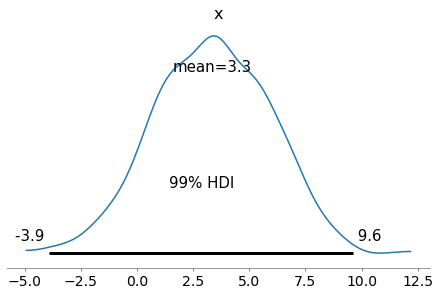

In [30]:
# Aggregate posteriors of the parameters to point estimates 
intercept_coef = 1.280420110434809 # np.mean(intercept_draws)
sneakers_coef = 0.10359376097356286 # np.mean(sneakers_draws)
clothes_coef = 0.10459390077643661 # np.mean(clothes_draws)
sd_coef = 2.651661160056662 # np.mean(sd_draws)

# Calculate the mean of the predictive distribution
pred_mean = intercept_coef + sneakers_coef * 10 + clothes_coef * 10

# Sample 1000 draws from the predictive distribution
pred_draws = np.random.normal(pred_mean, sd_coef, size=1000)

# Plot the density of the predictive distribution
pm.plot_posterior(pred_draws, hdi_prob=0.99)
plt.show()

It looks like we can expect more or less three or four clicks if we show 10 clothes and 10 sneaker ads. Head off to the final chapter of the course where we will be using the `pymc3` package to carry out a full-fledged Bayesian linear regression analysis!

## 4. Bayesian linear regression with pyMC3

In this final chapter, we’ll take advantage of the powerful PyMC3 package to easily fit Bayesian regression models, conduct sanity checks on a model's convergence, select between competing models, and generate predictions for new data. To wrap up, we’ll apply what we’ve learned to find the optimal price for avocados in a Bayesian data analysis case study.

#### 4.1 Markov Chain Monte Carlo and model fitting

Markov Chain Monte Carlo, or MCMC, combines the concepts of Monte Carlo sampling with Markov Chains' property of converging to a steady state. This allows sampling draws from any, even unknown, posterior distribution. Some fact regarding the MCMC:
- Monte Carlo is a way to approximate some quantity by generating random numbers.
- Numbers generated by MCMC become draws from the posterior after many samples thanks to Markov Chains'.
- Using MCMC to get posterior draws will give the same results as using grid approximation or sampling from the posterior directly (if it's known).
- We don't need to know the right conjugate priors when using MCMC.
- We can use only part of the draws generated in the MCMC process as draws from the parameter's posterior distribution.

MCMC sampling is quite hard to get one's head around. 


SCENARIO: _Tired of working for the central government and for the marketing company, you take a new job as a data analyst for your city's local authorities. The city operates a bike-sharing system in the city and they ask you to predict the number of bikes rented per day to plan staff and repairs accordingly._

For this exersice we will use data from [Bike Sharing Demand](https://www.kaggle.com/competitions/bike-sharing-demand/data). But first we need to preprocess the data for this exercise:
1. Do daily aggrigation `np.mean`
2. Leave only the following columns: `[workday, temp, humidity, windspeed, num_bikes]`


In [53]:
# load full data set and preview the table
bike = pd.read_csv("data/bike-sharing-demand/train.csv", parse_dates=['datetime'])
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [32]:
bike.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [33]:
# preprocces the data
bike_daily = bike.resample('D', on='datetime').mean()
bike_daily.rename(columns={"count": "num_bikes"}, inplace=True)
bike_daily = bike_daily[['workingday', 'temp', 'humidity', 'windspeed', 'num_bikes']]
bike_daily.dropna(axis=0, inplace=True) # for missing days we will have an empty row
bike_daily.head()

,workingday,temp,humidity,windspeed,num_bikes
datetime,,,,,
2011-01-01,0.0,14.110833,80.583333,10.749871,41.041667
2011-01-02,0.0,14.902609,69.608696,16.652122,34.826087
2011-01-03,1.0,8.050909,43.727273,16.636709,61.318182
2011-01-04,1.0,8.200000,59.043478,10.739809,67.913043
2011-01-05,1.0,9.305217,43.695652,12.522300,69.565217


Now, we will try building a regression model to predict `num_bikes` using the bikes DataFrame and `pymc3` (aliased as pm).

In [34]:
# splitting the data into train and test
# to speed up the process we will use part of the data
sample_bike = bike_daily.sample(n=60, random_state=42)
bike_train = sample_bike.sample(n=40, random_state=42)
bike_test = sample_bike.drop(bike_train.index)

In [35]:
%%time
formula = "num_bikes ~ temp + workingday"

with pm.Model() as model_1:
    
    pm.GLM.from_formula(formula, data=bike_train)
    
    # Print model specification
    print(model_1)
    
    # Sample posterior draws
    trace_1 = pm.sample(draws=1000, tune=500)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


 Intercept ~ Flat
      temp ~ Normal
workingday ~ Normal
  sd_log__ ~ TransformedDistribution
        sd ~ HalfCauchy
         y ~ Normal


<timed exec>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, workingday, temp, Intercept]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 463 seconds.
The acceptance probability does not match the target. It is 0.8956955069807339, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928503028480397, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: total: 44.5 s
Wall time: 8min 7s


In just a couple of lines of code we can sample posterior draws in a Bayesian linear regression model! Let's take a look at what to do with the resulting trace!

#### 4.1 Interpreting results and comparing models

We continue working on our task to predict the number of bikes rented per day in a bike-sharing system. The posterior draws from our regression model which we sampled before are available in our workspace as `trace_1`.

We know that after obtaining the posteriors, it is best practice to take a look at them to see if they make sense and if the MCMC process has converged successfully. In this exercise, we will create two plots visualizing posterior draws and summarize them in a table. Let's inspect our posteriors!

<timed exec>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


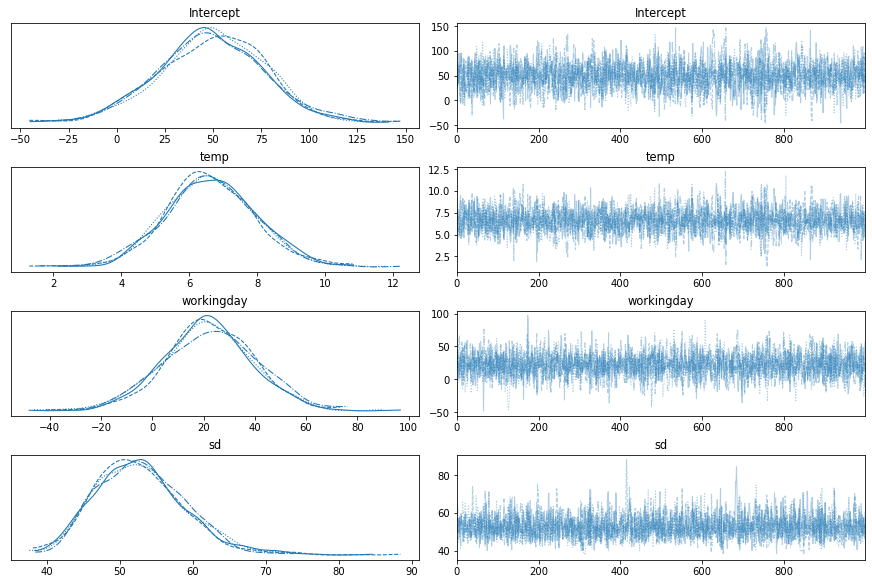

<timed exec>:6: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


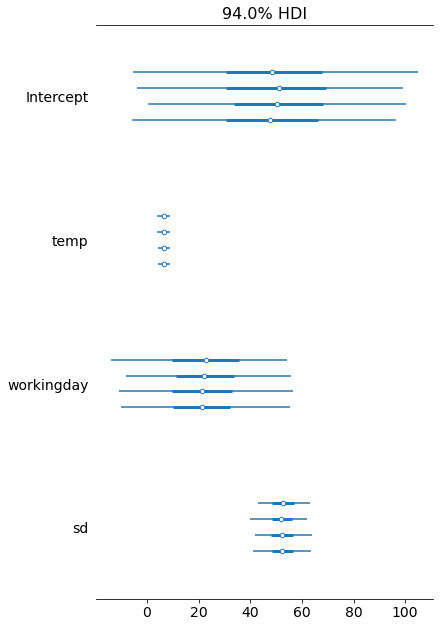

CPU times: total: 51.7 s
Wall time: 52 s


In [36]:
%%time
# Draw a trace plot of trace_1
pm.traceplot(trace_1)
plt.show()

# Draw a forest plot of trace_1
pm.forestplot(trace_1)
plt.show()

In [37]:
pm.summary(trace_1)

C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,49.170,27.678,-5.408,98.651,0.587,0.444,2237.0,2070.0,1.0
temp,6.625,1.324,4.066,8.975,0.028,0.020,2231.0,2108.0,1.0
workingday,22.015,17.767,-11.007,55.710,0.344,0.259,2695.0,2286.0,1.0
sd,52.821,6.117,42.221,64.059,0.130,0.092,2205.0,1707.0,1.0


In `model_1`:
- Number of parameters: 4.
- We had 4 chaines (default), and 1000 draws for each. Thus, number of draws for each parameter: 1000 × 4 = 4000 

Based on the table and the two plots above, we can say that:

- Judging by the trace plot, sampling for all parameters has converged successfully. Based on the trace plot, the density plots for different chains are very similar for each parameter, and the subsequent samples oscilate around a constant average. This indicates the sampling has converged well!
- Given the 94% credible interval, we are not sure whether more bikes are rented in the working week than in the weekends. Based on the forest plot, the lower end of the 94% interaval is below zero, and the upper end is postive. Hence, with 94% confidence, we cannot say whether the impact of `work_day` is positive or negative!
- The R-hat statistic signifies a successful convergence. R-hat values above 1 signify convergence issues, and here R-hat is exactly 1 for all parameters, which denotes a successful convergence.

Now that we have successfully built the first, basic model, we take another look at the data at our disposal. We notice a variable called `wind_speed`. This could be a great predictor of the numbers of bikes rented! Cycling against the wind is not that much fun, is it?

Let's fit another model with this additional predictor:

In [38]:
bike_train.head()

,workingday,temp,humidity,windspeed,num_bikes
datetime,,,,,
2012-08-13,1.0,29.554167,54.541667,9.126238,286.791667
2011-11-10,1.0,15.580000,81.333333,12.667467,122.208333
2012-03-16,1.0,17.869167,84.208333,7.583842,182.416667
2011-04-19,1.0,20.739167,66.583333,10.584046,133.500000
2012-07-13,1.0,29.998333,48.583333,5.416950,312.458333


In [39]:
%%time
formula = "num_bikes ~ temp + workingday + windspeed"

with pm.Model() as model_2:
    pm.GLM.from_formula(formula, data=bike_train)
    trace_2 = pm.sample(draws=1000, tune = 500)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
<timed exec>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, windspeed, workingday, temp, Intercept]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 592 seconds.
The acceptance probability does not match the target. It is 0.8950615333401438, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: total: 46.3 s
Wall time: 10min 15s


Is our new `model_2` better than `model_1`, the one without wind speed? Let's compare the two models using Widely Applicable Information Criterion, or WAIC, to find out!

C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\DmitriGazizulin\anaconda3\envs\intr

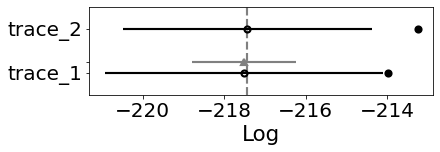

CPU times: total: 35.1 s
Wall time: 35.7 s


In [40]:
%%time
# Gather trace_1 and trace_2 into a dictionary
traces_dict = {"trace_1": trace_1, "trace_2": trace_2}

# Create a comparison table based on WAIC
comparison = pm.compare(traces_dict, ic="waic")

# Draw a comparison plot
pm.compareplot(comparison, textsize=20)
plt.show()

In [41]:
print(comparison)

         rank        waic    p_waic    d_waic   weight        se       dse  \
trace_2     0 -217.432376  4.179095  0.000000  0.55102  3.056327  0.000000   
trace_1     1 -217.517424  3.535446  0.085047  0.44898  3.414121  1.274598   

         warning waic_scale  
trace_2     True        log  
trace_1     True        log  


In the comparison plot:
- The _empty circles_ show the `waic` values. The larger the `waic`, the better the model.
- The _black bars_ show the std of the `waic`.
- The _grey triangle_ shows the difference between the bottom and the top models, i.e., `model_1` vs `model_2`. 
- The _grey bar_ shows the difference in WAIC between the two models, plus/minus one standard deviation. Meaning, how confident we are in our decision the `model_2` is better than `model_1`. 

Based on the table, and on the comparison plot we have just drawn, we can say:
- Based only on the WAIC value: WAIC for `model_2` is slightly larger, indicating `model_2` fits the data better than `model_1`.
- Based on the _gray triangle_ in the compare plot: It shows the difference in WAIC between the two models, and the right hand side of it overlaps with the `model_2`'s WAIC. This indicates that `model_2`'s WAIC is not necessarily larger then `model_1`'s.
- The `weight` of 0.44898 for `model_1` indicates it is the true model with almost 44% probability. Whereas, the `weight` of 0.55102 for `model_2` indicates it is the true model with almost 55% probability.

#### 4.3 Making predictions

Finally! Our job is to predict the number of bikes rented per day, and we are almost there. We have fitted the model and verified the quality of parameter draws. We have also chosen the better of the two competing models based on the WAIC. Now, it's time to use our best model to make predictions!

A couple of new observations, not seen by the model, have been collected in a DataFrame named `bike_test`. For each of them, we know the true number of bikes rented, which will allow us to evaluate model performance. In this exercise, we will get familiar with the test data and generate predictive draws for every test observation. 

In [42]:
# Print bikes_test head
print(bike_test.head())

# Define the formula
formula = "num_bikes ~ temp + workingday + windspeed"

# Generate predictive draws
with pm.Model() as model:
    pm.GLM.from_formula(formula, data=bike_test)
    posterior_predictive = pm.fast_sample_posterior_predictive(trace_2)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


            workingday       temp   humidity  windspeed   num_bikes
datetime                                                           
2011-03-02         1.0  13.735000  44.958333  20.624833   88.916667
2012-06-18         1.0  23.301667  77.791667  11.707971  212.458333
2011-06-07         1.0  29.007500  59.791667  12.583158  201.375000
2011-04-16         0.0  17.664167  88.833333  22.834158   33.125000
2012-09-01         0.0  30.886667  63.833333   7.583563  255.833333


Now that we have our `posterior_predictive`, we can evaluate model performance on new data. To do this, we will need to loop over the test observations, and for each of them, compute the prediction error as the difference between the predictive distribution for this observation and the actual, true value. This will give us the distribution of your model's error, which we can then visualize.

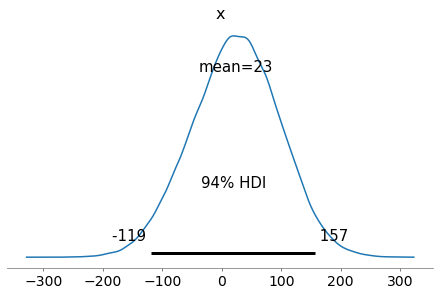

In [43]:
# Initialize errors
errors = []

# Iterate over rows of bikes_test to compute error per row
for index, test_example in bike_test.reset_index().iterrows():
    error = posterior_predictive['y'][:, index] - test_example['num_bikes']
    errors.append(error)

# Reshape errors
error_distribution = np.array(errors).reshape(-1)

# Plot the error distribution
pm.plot_posterior(error_distribution)
plt.show()

In [44]:
bike_daily.describe()

,workingday,temp,humidity,windspeed,num_bikes
count,456.000000,456.000000,456.000000,456.000000,456.000000
mean,0.682018,20.186671,61.889357,12.805332,191.022535
std,0.466204,7.379281,14.192906,5.129944,77.397273
min,0.000000,4.407500,0.000000,1.500242,26.304348
25%,0.000000,14.068125,51.218750,9.199956,138.291667
50%,1.000000,20.551250,61.854167,12.146123,191.062500
75%,1.000000,26.615833,71.843750,15.612960,250.072917
max,1.000000,35.328333,97.041667,33.999988,363.083333


Based on the `error distribution` plot, the average error in the prediction is 23 bikes. Based on the statistics of the `num_bikes`, the mean and median bike count is ~191. Does the average error of 23 bikes satisfy us? 🙄

In practice, we might want to compute the error estimate based on more than just 20 observations, but we can already see some patterns. For example, the error is more often positive than negative, which means that the model tends to overpredict the number of bikes rented!

To wrap up this course, we’ll apply what we’ve learned to find the optimal price for avocados in a Bayesian data analysis case study. Fot this we will use a new notebook `how_much_is_an_avocado`.